# Assignment2

### Run some setup code for this notebook.

In [5]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Load the raw CIFAR-10 data.

In [93]:
from torch.utils.data import Dataset, DataLoader
class imageDataset(Dataset):
    def __init__(self, cifar10_dir, train=True, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X_train, self.y_train, self.X_test, self.y_test = load_CIFAR10(cifar10_dir)
        self.train = train
        self.transform = transform

    def __len__(self):
        if self.train:
            return len(X_train)
        else:
            return len(X_test)

    def __getitem__(self, idx):
        if self.train:
            image = self.X_train[idx]
            label = self.y_train[idx]
        else:
            image = self.X_test[idx]
            label = self.y_test[idx]

        if self.transform:
            image = self.transform(image)

        return (image,label)

## Generate the training dataset and test dataset

In [99]:
import torch
import torchvision
import torchvision.transforms as transforms

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
cifar10_dir = './cs231n/datasets/cifar-10-batches-py'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = imageDataset(cifar10_dir=cifar10_dir,train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = imageDataset(cifar10_dir=cifar10_dir,train=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [107]:
trainset.X_test.shape

(10000, 32, 32, 3)

 ship plane plane  ship


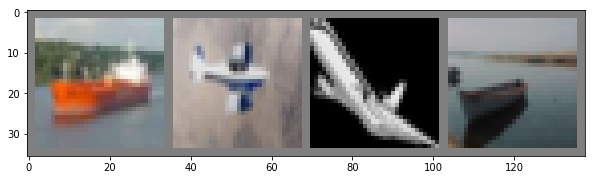

In [95]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

########################################################################
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Define a Neural Network

In [122]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [113]:
class TwoLayerNet(nn.Module):
    def __init__(self):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [114]:
class ThreeLayerNet(nn.Module):
    def __init__(self):
        super(ThreeLayerNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [123]:
net = ConvNet()
print(net)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Train the network

In [124]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.257
[1,  4000] loss: 1.873
[1,  6000] loss: 1.719
[1,  8000] loss: 1.605
[1, 10000] loss: 1.534
[1, 12000] loss: 1.491
[2,  2000] loss: 1.431
[2,  4000] loss: 1.408
[2,  6000] loss: 1.356
[2,  8000] loss: 1.369
[2, 10000] loss: 1.317
[2, 12000] loss: 1.292
[3,  2000] loss: 1.226
[3,  4000] loss: 1.234
[3,  6000] loss: 1.227
[3,  8000] loss: 1.215
[3, 10000] loss: 1.198
[3, 12000] loss: 1.184
[4,  2000] loss: 1.132
[4,  4000] loss: 1.119
[4,  6000] loss: 1.127
[4,  8000] loss: 1.135
[4, 10000] loss: 1.117
[4, 12000] loss: 1.115
[5,  2000] loss: 1.015
[5,  4000] loss: 1.050
[5,  6000] loss: 1.053
[5,  8000] loss: 1.057
[5, 10000] loss: 1.047
[5, 12000] loss: 1.077
[6,  2000] loss: 0.967
[6,  4000] loss: 0.980
[6,  6000] loss: 0.979
[6,  8000] loss: 1.004
[6, 10000] loss: 0.988
[6, 12000] loss: 1.027
[7,  2000] loss: 0.902
[7,  4000] loss: 0.914
[7,  6000] loss: 0.941
[7,  8000] loss: 0.960
[7, 10000] loss: 0.966
[7, 12000] loss: 0.949
[8,  2000] loss: 0.839
[8,  4000] 

## Test the network on the test data

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car   car  ship
Accuracy of the network on the 10000 test images: 60 %
Accuracy of plane : 65 %
Accuracy of   car : 81 %
Accuracy of  bird : 50 %
Accuracy of   cat : 38 %
Accuracy of  deer : 50 %
Accuracy of   dog : 59 %
Accuracy of  frog : 66 %
Accuracy of horse : 56 %
Accuracy of  ship : 76 %
Accuracy of truck : 62 %


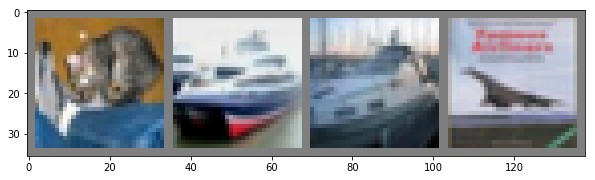

In [125]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(Variable(images))

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

### Output when training the ConvNet
[1,  2000] loss: 2.257
[1,  4000] loss: 1.873
[1,  6000] loss: 1.719
[1,  8000] loss: 1.605
[1, 10000] loss: 1.534
[1, 12000] loss: 1.491
[2,  2000] loss: 1.431
[2,  4000] loss: 1.408
[2,  6000] loss: 1.356
[2,  8000] loss: 1.369
[2, 10000] loss: 1.317
[2, 12000] loss: 1.292
[3,  2000] loss: 1.226
[3,  4000] loss: 1.234
[3,  6000] loss: 1.227
[3,  8000] loss: 1.215
[3, 10000] loss: 1.198
[3, 12000] loss: 1.184
[4,  2000] loss: 1.132
[4,  4000] loss: 1.119
[4,  6000] loss: 1.127
[4,  8000] loss: 1.135
[4, 10000] loss: 1.117
[4, 12000] loss: 1.115
[5,  2000] loss: 1.015
[5,  4000] loss: 1.050
[5,  6000] loss: 1.053
[5,  8000] loss: 1.057
[5, 10000] loss: 1.047
[5, 12000] loss: 1.077
[6,  2000] loss: 0.967
[6,  4000] loss: 0.980
[6,  6000] loss: 0.979
[6,  8000] loss: 1.004
[6, 10000] loss: 0.988
[6, 12000] loss: 1.027
[7,  2000] loss: 0.902
[7,  4000] loss: 0.914
[7,  6000] loss: 0.941
[7,  8000] loss: 0.960
[7, 10000] loss: 0.966
[7, 12000] loss: 0.949
[8,  2000] loss: 0.839
[8,  4000] loss: 0.875
[8,  6000] loss: 0.916
[8,  8000] loss: 0.893
[8, 10000] loss: 0.921
[8, 12000] loss: 0.922
[9,  2000] loss: 0.796
[9,  4000] loss: 0.846
[9,  6000] loss: 0.873
[9,  8000] loss: 0.858
[9, 10000] loss: 0.902
[9, 12000] loss: 0.907
[10,  2000] loss: 0.791
[10,  4000] loss: 0.822
[10,  6000] loss: 0.833
[10,  8000] loss: 0.839
[10, 10000] loss: 0.851
[10, 12000] loss: 0.854
[11,  2000] loss: 0.748
[11,  4000] loss: 0.778
[11,  6000] loss: 0.816
[11,  8000] loss: 0.810
[11, 10000] loss: 0.833
[11, 12000] loss: 0.855
[12,  2000] loss: 0.740
[12,  4000] loss: 0.765
[12,  6000] loss: 0.776
[12,  8000] loss: 0.795
[12, 10000] loss: 0.806
[12, 12000] loss: 0.826
[13,  2000] loss: 0.703
[13,  4000] loss: 0.736
[13,  6000] loss: 0.756
[13,  8000] loss: 0.766
[13, 10000] loss: 0.786
[13, 12000] loss: 0.820
[14,  2000] loss: 0.698
[14,  4000] loss: 0.703
[14,  6000] loss: 0.773
[14,  8000] loss: 0.739
[14, 10000] loss: 0.779
[14, 12000] loss: 0.794
[15,  2000] loss: 0.659
[15,  4000] loss: 0.687
[15,  6000] loss: 0.710
[15,  8000] loss: 0.732
[15, 10000] loss: 0.755
[15, 12000] loss: 0.783
[16,  2000] loss: 0.645
[16,  4000] loss: 0.688
[16,  6000] loss: 0.706
[16,  8000] loss: 0.720
[16, 10000] loss: 0.727
[16, 12000] loss: 0.756
[17,  2000] loss: 0.633
[17,  4000] loss: 0.661
[17,  6000] loss: 0.705
[17,  8000] loss: 0.732
[17, 10000] loss: 0.753
[17, 12000] loss: 0.714
[18,  2000] loss: 0.614
[18,  4000] loss: 0.662
[18,  6000] loss: 0.693
[18,  8000] loss: 0.710
[18, 10000] loss: 0.711
[18, 12000] loss: 0.716
[19,  2000] loss: 0.604
[19,  4000] loss: 0.636
[19,  6000] loss: 0.664
[19,  8000] loss: 0.695
[19, 10000] loss: 0.699
[19, 12000] loss: 0.728
[20,  2000] loss: 0.599
[20,  4000] loss: 0.633
[20,  6000] loss: 0.667
[20,  8000] loss: 0.684
[20, 10000] loss: 0.707
[20, 12000] loss: 0.711
Finished Training

### Output when testing the ConvNet 
Accuracy of the network on the 10000 test images: 60 %
Accuracy of plane : 65 %
Accuracy of   car : 81 %
Accuracy of  bird : 50 %
Accuracy of   cat : 38 %
Accuracy of  deer : 50 %
Accuracy of   dog : 59 %
Accuracy of  frog : 66 %
Accuracy of horse : 56 %
Accuracy of  ship : 76 %
Accuracy of truck : 62 %

### Output when training the 2-layer Network
[1,  2000] loss: 1.845
[1,  4000] loss: 1.699
[1,  6000] loss: 1.651
[1,  8000] loss: 1.610
[1, 10000] loss: 1.611
[1, 12000] loss: 1.588
[2,  2000] loss: 1.509
[2,  4000] loss: 1.529
[2,  6000] loss: 1.492
[2,  8000] loss: 1.504
[2, 10000] loss: 1.489
[2, 12000] loss: 1.492
[3,  2000] loss: 1.420
[3,  4000] loss: 1.409
[3,  6000] loss: 1.448
[3,  8000] loss: 1.418
[3, 10000] loss: 1.436
[3, 12000] loss: 1.418
[4,  2000] loss: 1.355
[4,  4000] loss: 1.351
[4,  6000] loss: 1.379
[4,  8000] loss: 1.376
[4, 10000] loss: 1.394
[4, 12000] loss: 1.390
[5,  2000] loss: 1.320
[5,  4000] loss: 1.307
[5,  6000] loss: 1.327
[5,  8000] loss: 1.347
[5, 10000] loss: 1.334
[5, 12000] loss: 1.335
[6,  2000] loss: 1.257
[6,  4000] loss: 1.286
[6,  6000] loss: 1.293
[6,  8000] loss: 1.297
[6, 10000] loss: 1.315
[6, 12000] loss: 1.287
[7,  2000] loss: 1.209
[7,  4000] loss: 1.253
[7,  6000] loss: 1.248
[7,  8000] loss: 1.281
[7, 10000] loss: 1.282
[7, 12000] loss: 1.273
[8,  2000] loss: 1.188
[8,  4000] loss: 1.204
[8,  6000] loss: 1.204
[8,  8000] loss: 1.248
[8, 10000] loss: 1.268
[8, 12000] loss: 1.258
[9,  2000] loss: 1.144
[9,  4000] loss: 1.167
[9,  6000] loss: 1.208
[9,  8000] loss: 1.212
[9, 10000] loss: 1.234
[9, 12000] loss: 1.233
[10,  2000] loss: 1.134
[10,  4000] loss: 1.174
[10,  6000] loss: 1.168
[10,  8000] loss: 1.194
[10, 10000] loss: 1.191
[10, 12000] loss: 1.192
[11,  2000] loss: 1.093
[11,  4000] loss: 1.164
[11,  6000] loss: 1.137
[11,  8000] loss: 1.164
[11, 10000] loss: 1.163
[11, 12000] loss: 1.171
[12,  2000] loss: 1.061
[12,  4000] loss: 1.103
[12,  6000] loss: 1.154
[12,  8000] loss: 1.144
[12, 10000] loss: 1.157
[12, 12000] loss: 1.155
[13,  2000] loss: 1.067
[13,  4000] loss: 1.092
[13,  6000] loss: 1.081
[13,  8000] loss: 1.122
[13, 10000] loss: 1.113
[13, 12000] loss: 1.143
[14,  2000] loss: 1.021
[14,  4000] loss: 1.069
[14,  6000] loss: 1.084
[14,  8000] loss: 1.082
[14, 10000] loss: 1.102
[14, 12000] loss: 1.138
[15,  2000] loss: 1.009
[15,  4000] loss: 1.069
[15,  6000] loss: 1.035
[15,  8000] loss: 1.073
[15, 10000] loss: 1.121
[15, 12000] loss: 1.068
[16,  2000] loss: 0.992
[16,  4000] loss: 1.023
[16,  6000] loss: 1.060
[16,  8000] loss: 1.028
[16, 10000] loss: 1.072
[16, 12000] loss: 1.086
[17,  2000] loss: 0.972
[17,  4000] loss: 0.988
[17,  6000] loss: 1.031
[17,  8000] loss: 1.033
[17, 10000] loss: 1.056
[17, 12000] loss: 1.071
[18,  2000] loss: 0.952
[18,  4000] loss: 1.003
[18,  6000] loss: 0.994
[18,  8000] loss: 0.992
[18, 10000] loss: 1.036
[18, 12000] loss: 1.037
[19,  2000] loss: 0.940
[19,  4000] loss: 0.974
[19,  6000] loss: 0.983
[19,  8000] loss: 1.003
[19, 10000] loss: 1.002
[19, 12000] loss: 1.032
[20,  2000] loss: 0.920
[20,  4000] loss: 0.931
[20,  6000] loss: 0.996
[20,  8000] loss: 0.974
[20, 10000] loss: 0.989
[20, 12000] loss: 1.016
Finished Training

### Output when testing the 2-layer network
Accuracy of the network on the 10000 test images: 48 %
Accuracy of plane : 57 %
Accuracy of   car : 55 %
Accuracy of  bird : 37 %
Accuracy of   cat : 23 %
Accuracy of  deer : 40 %
Accuracy of   dog : 52 %
Accuracy of  frog : 55 %
Accuracy of horse : 50 %
Accuracy of  ship : 59 %
Accuracy of truck : 50 %

### Output when training the 3-layer network
[1,  2000] loss: 1.941
[1,  4000] loss: 1.744
[1,  6000] loss: 1.653
[1,  8000] loss: 1.627
[1, 10000] loss: 1.604
[1, 12000] loss: 1.558
[2,  2000] loss: 1.506
[2,  4000] loss: 1.469
[2,  6000] loss: 1.483
[2,  8000] loss: 1.474
[2, 10000] loss: 1.452
[2, 12000] loss: 1.432
[3,  2000] loss: 1.362
[3,  4000] loss: 1.386
[3,  6000] loss: 1.384
[3,  8000] loss: 1.365
[3, 10000] loss: 1.371
[3, 12000] loss: 1.361
[4,  2000] loss: 1.267
[4,  4000] loss: 1.306
[4,  6000] loss: 1.305
[4,  8000] loss: 1.302
[4, 10000] loss: 1.320
[4, 12000] loss: 1.328
[5,  2000] loss: 1.215
[5,  4000] loss: 1.254
[5,  6000] loss: 1.245
[5,  8000] loss: 1.278
[5, 10000] loss: 1.238
[5, 12000] loss: 1.261
[6,  2000] loss: 1.188
[6,  4000] loss: 1.168
[6,  6000] loss: 1.196
[6,  8000] loss: 1.221
[6, 10000] loss: 1.222
[6, 12000] loss: 1.226
[7,  2000] loss: 1.129
[7,  4000] loss: 1.155
[7,  6000] loss: 1.165
[7,  8000] loss: 1.171
[7, 10000] loss: 1.178
[7, 12000] loss: 1.173
[8,  2000] loss: 1.095
[8,  4000] loss: 1.119
[8,  6000] loss: 1.115
[8,  8000] loss: 1.131
[8, 10000] loss: 1.136
[8, 12000] loss: 1.163
[9,  2000] loss: 1.039
[9,  4000] loss: 1.069
[9,  6000] loss: 1.097
[9,  8000] loss: 1.116
[9, 10000] loss: 1.111
[9, 12000] loss: 1.110
[10,  2000] loss: 1.024
[10,  4000] loss: 1.061
[10,  6000] loss: 1.070
[10,  8000] loss: 1.070
[10, 10000] loss: 1.065
[10, 12000] loss: 1.088
[11,  2000] loss: 0.989
[11,  4000] loss: 1.022
[11,  6000] loss: 1.026
[11,  8000] loss: 1.046
[11, 10000] loss: 1.053
[11, 12000] loss: 1.055
[12,  2000] loss: 0.974
[12,  4000] loss: 1.002
[12,  6000] loss: 0.994
[12,  8000] loss: 1.008
[12, 10000] loss: 1.040
[12, 12000] loss: 1.038
[13,  2000] loss: 0.928
[13,  4000] loss: 0.978
[13,  6000] loss: 0.988
[13,  8000] loss: 0.989
[13, 10000] loss: 0.999
[13, 12000] loss: 1.021
[14,  2000] loss: 0.921
[14,  4000] loss: 0.931
[14,  6000] loss: 0.953
[14,  8000] loss: 0.972
[14, 10000] loss: 0.993
[14, 12000] loss: 0.985
[15,  2000] loss: 0.880
[15,  4000] loss: 0.915
[15,  6000] loss: 0.952
[15,  8000] loss: 0.954
[15, 10000] loss: 0.963
[15, 12000] loss: 0.962
[16,  2000] loss: 0.865
[16,  4000] loss: 0.907
[16,  6000] loss: 0.898
[16,  8000] loss: 0.937
[16, 10000] loss: 0.938
[16, 12000] loss: 0.948
[17,  2000] loss: 0.837
[17,  4000] loss: 0.884
[17,  6000] loss: 0.875
[17,  8000] loss: 0.915
[17, 10000] loss: 0.910
[17, 12000] loss: 0.943
[18,  2000] loss: 0.841
[18,  4000] loss: 0.858
[18,  6000] loss: 0.884
[18,  8000] loss: 0.876
[18, 10000] loss: 0.909
[18, 12000] loss: 0.892
[19,  2000] loss: 0.802
[19,  4000] loss: 0.870
[19,  6000] loss: 0.853
[19,  8000] loss: 0.868
[19, 10000] loss: 0.876
[19, 12000] loss: 0.893
[20,  2000] loss: 0.779
[20,  4000] loss: 0.820
[20,  6000] loss: 0.847
[20,  8000] loss: 0.858
[20, 10000] loss: 0.865
[20, 12000] loss: 0.872
Finished Training

### Output when testing 3-layer network
Accuracy of the network on the 10000 test images: 51 %
Accuracy of plane : 65 %
Accuracy of   car : 57 %
Accuracy of  bird : 33 %
Accuracy of   cat : 26 %
Accuracy of  deer : 46 %
Accuracy of   dog : 44 %
Accuracy of  frog : 65 %
Accuracy of horse : 57 %
Accuracy of  ship : 61 %
Accuracy of truck : 58 %